In [1]:
%pylab inline
import os.path as op
import sys
import os

import json

Populating the interactive namespace from numpy and matplotlib


## Import openslide

In [2]:
pth = op.expanduser(r"~\Downloads\openslide\openslide-win64\bin")
# pth = op.expanduser(r"~\projects\scaffan\devel\knihovny")
# pth = op.expanduser(r"~\Miniconda3\envs\lisa36\Library\bin")
sys.path.insert(0, pth)
orig_PATH = os.environ["PATH"]
os.environ["PATH"] = pth + ";" + os.environ["PATH"]

In [3]:
# import numpy as np
import openslide as opsl

# Work with image data

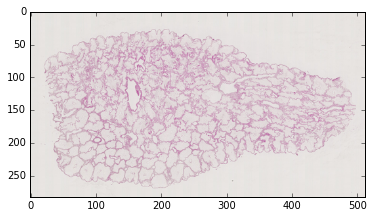

In [4]:
pth = r"E:/data/scaffold/Hamamatsu/PIG-008_P008 LL-P_HE_parenchyme perif..ndpi"
imsl = opsl.OpenSlide(pth)
imthumb = imsl.get_thumbnail((512, 512))

plt.imshow(imthumb)

In [5]:
imsl.level_dimensions

((90112, 49920),
 (45056, 24960),
 (22528, 12480),
 (11264, 6240),
 (5632, 3120),
 (2816, 1560),
 (1408, 780),
 (704, 390),
 (352, 195))

In [6]:
imsl.level_downsamples

(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0)

## Resolution

In [7]:
pm = imsl.properties
resolution_unit = pm.get("tiff.ResolutionUnit")
resolution_x= pm.get("tiff.XResolution")
resolution_y= pm.get("tiff.YResolution")
print("Resolution {}x{} pixels/{}".format(resolution_x, resolution_y, resolution_unit))

Resolution 44005x43953 pixels/centimeter


In [8]:
imsl.dimensions

(90112, 49920)

In [9]:
# my annotataion area
kwargs_annotation_area = dict(
    location = (19000, 10000),
    level = 4,
    size = (1200, 900),
)

In [10]:
# one lobulus
kwargs_one_lobulus = dict(
    location = (19000, 10000),
    level = 4,
    size = (400, 400),
)

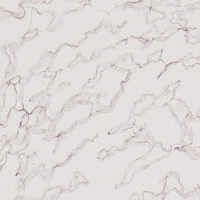

In [11]:
# one lobulus
kwargs_sample0 = dict(
    location = (10700, 21500),
    level = 2,
    size = (200, 200),
)
imsl.read_region(**kwargs_sample0)

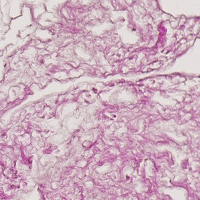

In [13]:
# one lobulus
kwargs_sample2 = dict(
    location = (15500, 14500),
    level = 2,
    size = (200, 200),
)
imsl.read_region(**kwargs_sample2)

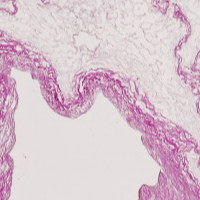

In [15]:
# one lobulus
kwargs_sample1 = dict(
    location = (26000, 17000),
    level = 4,
    size = (200, 200),
)
imsl.read_region(**kwargs_sample1)

In [27]:
# one lobulus
kwargs_sample_bigger = dict(
    location = (13000, 15000),
    level = 2,
    size = (3200, 3200),
)
# imsl.read_region(**kwargs_sample_bigger)

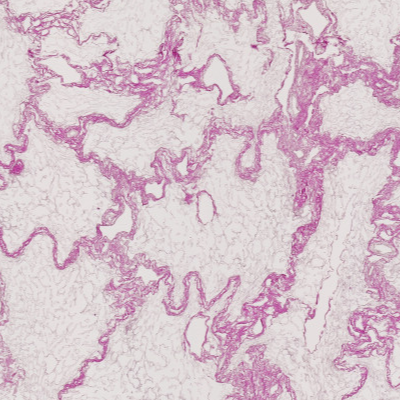

In [17]:
imcr = imsl.read_region(**kwargs_one_lobulus)
imcr

## Texture analysis

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.feature import local_binary_pattern

METHOD = 'uniform'
plt.rcParams['font.size'] = 9

view = [slice(1000, 1500), slice(1500, 2000)]



In [19]:
new_level = int(1)
location = kwargs_one_lobulus["location"]
former_level = kwargs_one_lobulus["level"]
former_size = kwargs_one_lobulus["size"]


imsl.level_downsamples

scale_factor = imsl.level_downsamples[former_level] / imsl.level_downsamples[new_level]
new_size = (np.asarray(former_size) * scale_factor).astype(np.int)

newimcr = imsl.read_region(location, new_level, new_size)
newimgr = skimage.color.rgb2gray(np.array(newimcr))

### LBP

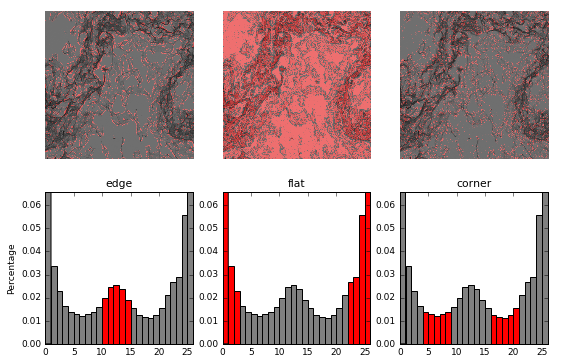

In [20]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


# image = data.load('brick.png')
image = newimgr[view]
lbp = local_binary_pattern(image, n_points, radius, METHOD)


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), normed=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(ymax=np.max(counts[:-1]))
    ax.set_xlim(xmax=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

Rotated images matched against references using LBP:
original: sample0, rotated: 30deg, match result:  sample1
original: sample1, rotated: 70deg, match result:  sample1
original: sample2, rotated: 145deg, match result:  sample1


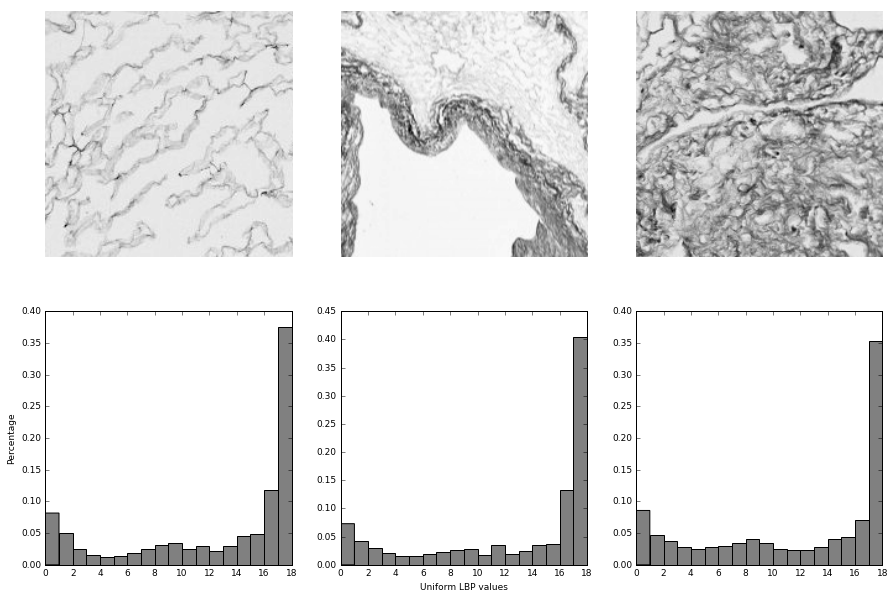

In [21]:
# settings for LBP
radius = 2
n_points = 8 * radius


def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))


def match(refs, img):
    best_score = 10
    best_name = None
    lbp = local_binary_pattern(img, n_points, radius, METHOD)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    for name, ref in refs.items():
        ref_hist, _ = np.histogram(ref, density=True, bins=n_bins,
                                   range=(0, n_bins))
        score = kullback_leibler_divergence(hist, ref_hist)
        if score < best_score:
            best_score = score
            best_name = name
    return best_name


sample0 = skimage.color.rgb2gray(np.asarray(imsl.read_region(**kwargs_sample0)))
sample1 = skimage.color.rgb2gray(np.asarray(imsl.read_region(**kwargs_sample1)))
sample2 = skimage.color.rgb2gray(np.asarray(imsl.read_region(**kwargs_sample2)))
# brick = data.load('brick.png')
# grass = data.load('grass.png')
# wall = data.load('rough-wall.png')

refs = {
    'sample0': local_binary_pattern(sample0, n_points, radius, METHOD),
    'sample1': local_binary_pattern(sample1, n_points, radius, METHOD),
    'sample2': local_binary_pattern(sample2, n_points, radius, METHOD)
}

# classify rotated textures
print('Rotated images matched against references using LBP:')
print('original: sample0, rotated: 30deg, match result: ',
      match(refs, rotate(sample0, angle=30, resize=False)))
print('original: sample1, rotated: 70deg, match result: ',
      match(refs, rotate(sample1, angle=70, resize=False)))
print('original: sample2, rotated: 145deg, match result: ',
      match(refs, rotate(sample2, angle=145, resize=False)))

# plot histograms of LBP of textures
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3,
                                                       figsize=(15, 10))
plt.gray()

ax1.imshow(sample0)
ax1.axis('off')
hist(ax4, refs['sample0'])
ax4.set_ylabel('Percentage')

ax2.imshow(sample1)
ax2.axis('off')
hist(ax5, refs['sample1'])
ax5.set_xlabel('Uniform LBP values')

ax3.imshow(sample2)
ax3.axis('off')
hist(ax6, refs['sample2'])

plt.show()

In [22]:
def texture_segmentation(image, decision_function, models, tile_size):
    output = np.asarray(image, dtype=np.int8)
    for x0 in range(0, image.shape[0], tile_size[0]):
        for x1 in range(0, image.shape[1], tile_size[1]):
            sl = [
                slice(x0, x0 + tile_size[0]),
                slice(x1, x1 + tile_size[1])
            ]
            output[sl] = decision_function(models, image[sl])
            
    return output
            
    

In [23]:
sample0 = skimage.color.rgb2gray(np.asarray(imsl.read_region(**kwargs_sample0)))
sample1 = skimage.color.rgb2gray(np.asarray(imsl.read_region(**kwargs_sample1)))
sample2 = skimage.color.rgb2gray(np.asarray(imsl.read_region(**kwargs_sample2)))
sample_bigger = skimage.color.rgb2gray(np.asarray(imsl.read_region(**kwargs_sample_bigger)))
# brick = data.load('brick.png')
# grass = data.load('grass.png')
# wall = data.load('rough-wall.png')

models = {
    1: local_binary_pattern(sample0, n_points, radius, METHOD),
#     2: local_binary_pattern(sample1, n_points, radius, METHOD),
    3: local_binary_pattern(sample2, n_points, radius, METHOD)
}

C:\Users\miros\Miniconda3\envs\lisa36\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Users\miros\Miniconda3\envs\lisa36\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


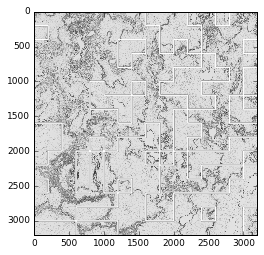

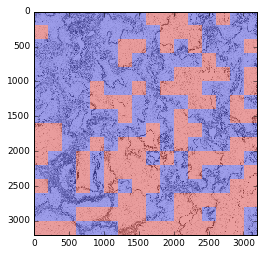

In [24]:
seg = texture_segmentation(sample_bigger, match, models, kwargs_sample0["size"])
figure()
imshow(sample_bigger)
contour(seg)
import skimage.color
figure()
imshow(skimage.color.label2rgb(seg, sample_bigger))

In [25]:
import skimage.morphology
# help(skimage.morphology.label)
skimage

<module 'skimage' from 'C:\\Users\\miros\\Miniconda3\\envs\\lisa36\\lib\\site-packages\\skimage\\__init__.py'>

In [26]:
meshgrid([1,5,10], [1,5,10])

[array([[ 1,  5, 10],
        [ 1,  5, 10],
        [ 1,  5, 10]]), array([[ 1,  1,  1],
        [ 5,  5,  5],
        [10, 10, 10]])]